## –ò—Ç–æ–≥–æ–≤–∞—è –∞—Ç—Ç–µ—Å—Ç–∞—Ü–∏—è

## –ò–º–ø–æ—Ä—Ç—ã –∏ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ

In [19]:
# import zipfile
# from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# import torch.nn.functional as F
# from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
# –ø—É—Ç—å –∫ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º (test –∏ train)
dataset_path = '/content/drive/MyDrive/Images/Birds'
# dataset_path = '/content/drive/MyDrive/Images/Animals'
# dataset_path = '/content/drive/MyDrive/Images/Family'

# –ø—É—Ç—å –∫ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—é (pred)
# –Ω–µ—Å–∫–æ–ª—å–∫–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π (animals, birds and other)
# pred_dataset_path = '/content/drive/MyDrive/Images/Images_pred'
# —Ñ–æ—Ç–æ
pred_dataset_path = '/content/drive/MyDrive/Images/Photo_pred'

In [21]:
# —Å–ª–æ–≤–∞—Ä—å –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
params_dict = {'num_epochs' : 10,       # –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö
               'batch_size' : 64,      # —Ä–∞–∑–º–µ—Ä batch
               'learning_rate' : 0.01, # learning_rate
               'device' : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),  # device
               'loss_function' : nn.CrossEntropyLoss(),   # —Ñ—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å
               'image_height' : 224,   # –≤—ã—Å–æ—Ç–∞ image –ø–æ—Å–ª–µ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏
               'image_width' : 224,    # —à–∏—Ä–∏–Ω–∞ image –ø–æ—Å–ª–µ –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏–∏
               }
params_dict

{'num_epochs': 10,
 'batch_size': 64,
 'learning_rate': 0.01,
 'device': device(type='cpu'),
 'loss_function': CrossEntropyLoss(),
 'image_height': 224,
 'image_width': 224}

In [22]:
os.listdir(dataset_path)

['–ß–µÃà—Ä–Ω—ã–∏ÃÜ –¥—Ä–æ–∑–¥',
 '–£—Ç–∫–∞',
 '–û—Ä–µÃà–ª',
 '–°–æ–∫–æ–ª',
 '–§–ª–∞–º–∏–Ω–≥–æ',
 '–ì—É—Å—å',
 '–Ø—Å—Ç—Ä–µ–±',
 '–°—Ç—Ä–∞—É—Å',
 '–°–æ–≤–∞',
 '–ü–∞–≤–ª–∏–Ω',
 '–ü–∏–Ω–≥–≤–∏–Ω']

In [23]:
os.listdir(pred_dataset_path)

['pred']

## –ü—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω—ã–π –ø—Ä–æ—Å–º–æ—Ç—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –¥–∞—Ç–∞—Å–µ—Ç–∞

In [24]:
transform_preview = transforms.Compose([
    transforms.Resize((params_dict['image_height'], params_dict['image_width'])),
    transforms.ToTensor()
])

# datasets.ImageFolder - —É–Ω–∏–≤–µ—Ä—Å–∞–ª—å–Ω—ã–π –∑–∞–≥—Ä—É–∑—á–∏–∫ –¥–∞–Ω–Ω—ã—Ö –∏–∑ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–∏ root, –≤ –∫–æ—Ç–æ—Ä–æ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é —Ä–∞—Å–ø–æ–ª–æ–∂–µ–Ω—ã —Å–ª–µ–¥—É—é—â–∏–º –æ–±—Ä–∞–∑–æ–º:
# root/dog/xxx.png
# root/dog/xxy.png
# root/dog/[...]/xxz.png
# root/cat/123.png
# root/cat/nsdf3.png
# root/cat/[...]/asd932_.png
# –∫–∞–∂–¥–∞—è –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—è - –∫–ª–∞—Å—Å, –∏–º—è –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–∏ - –∏–º—è –∫–ª–∞—Å—Å–∞
dataset_preview = datasets.ImageFolder(root=dataset_path, transform=transform_preview)
dataset_preview

Dataset ImageFolder
    Number of datapoints: 2376
    Root location: /content/drive/MyDrive/Images/Birds
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [25]:
class_names = dataset_preview.classes
class_names

['–ì—É—Å—å',
 '–û—Ä–µÃà–ª',
 '–ü–∞–≤–ª–∏–Ω',
 '–ü–∏–Ω–≥–≤–∏–Ω',
 '–°–æ–≤–∞',
 '–°–æ–∫–æ–ª',
 '–°—Ç—Ä–∞—É—Å',
 '–£—Ç–∫–∞',
 '–§–ª–∞–º–∏–Ω–≥–æ',
 '–ß–µÃà—Ä–Ω—ã–∏ÃÜ –¥—Ä–æ–∑–¥',
 '–Ø—Å—Ç—Ä–µ–±']

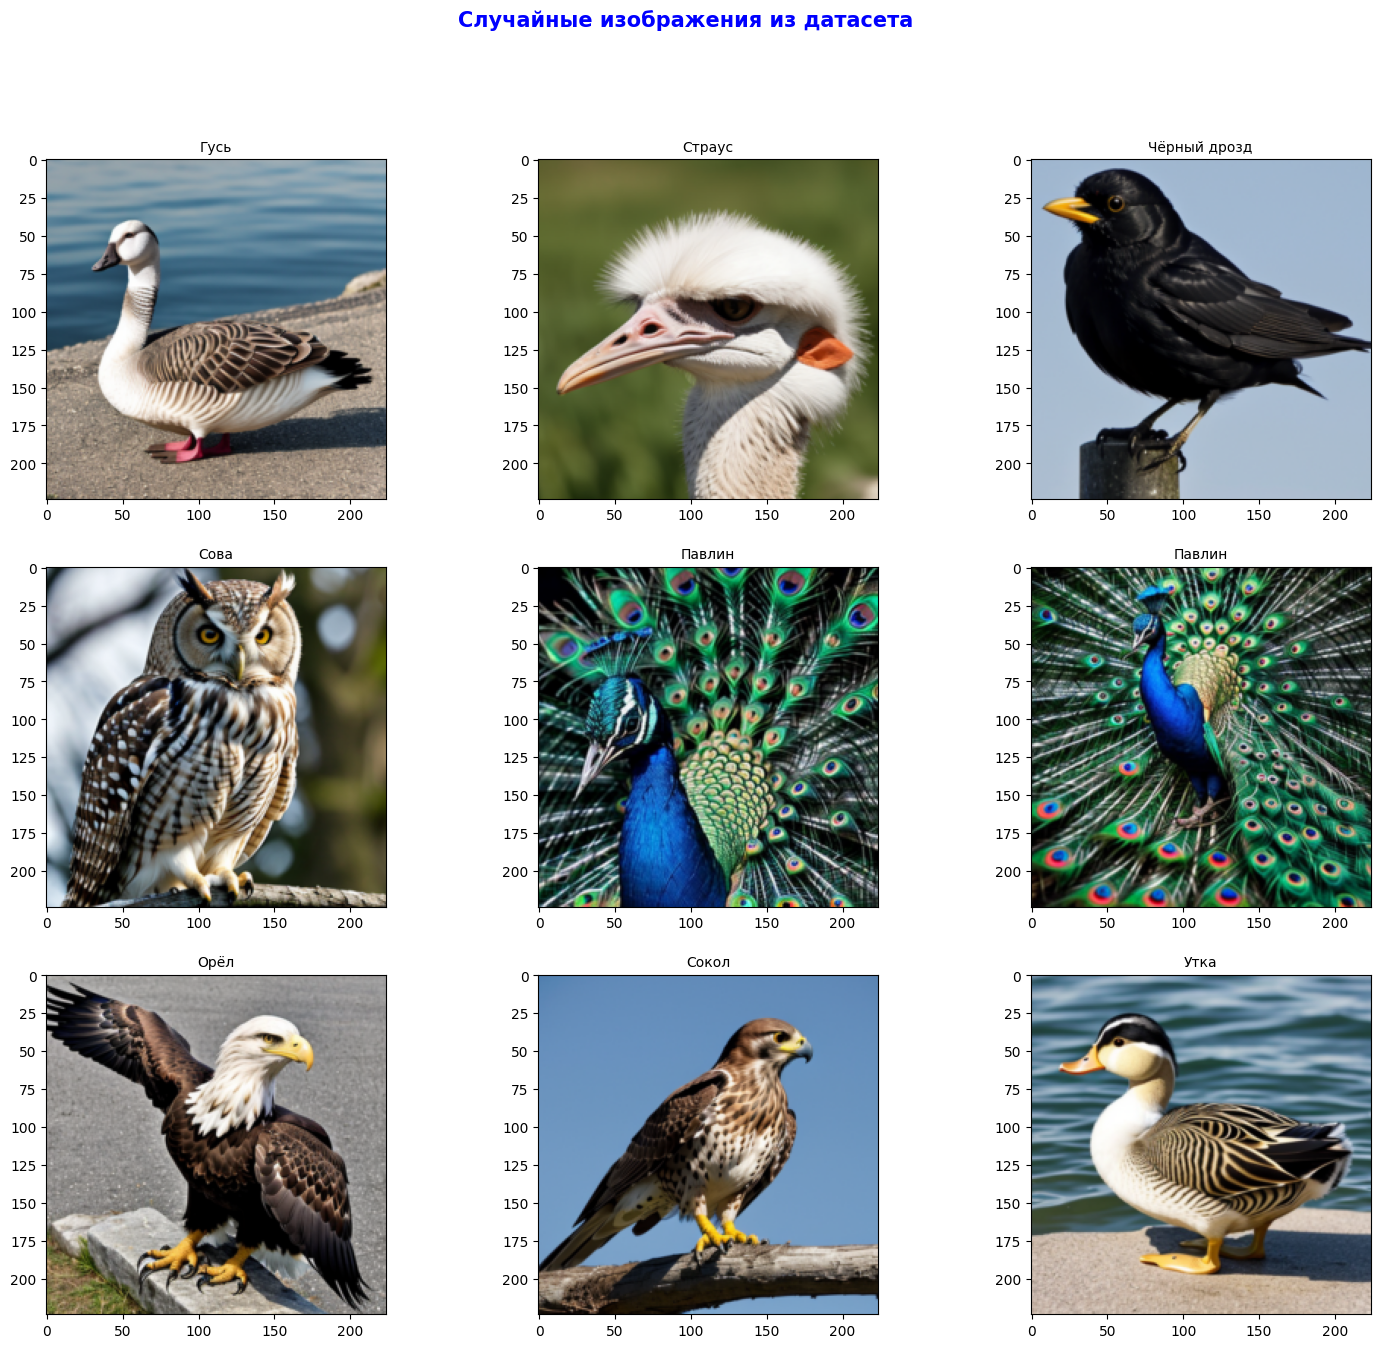

In [26]:
# figure
fig = plt.figure(figsize=(18, 15))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
  # —Å–ª—É—á–∞–π–Ω—ã–π –∏–Ω–¥–µ–∫—Å
  random_idx = torch.randint(0, len(dataset_preview), size=[1]).item()
  # image –∏ –º–µ—Ç–∫–∞
  img, label = dataset_preview[random_idx]
  fig.add_subplot(rows, cols, i)
  # –ø–æ–∫–∞–∑–∞—Ç—å image
  plt.imshow(img.permute(1, 2, 0))
  plt.suptitle('–°–ª—É—á–∞–π–Ω—ã–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –∏–∑ –¥–∞—Ç–∞—Å–µ—Ç–∞', fontsize=15, fontweight='bold', color='blue')
  plt.title(class_names[label], fontsize=10)

## –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö

In [27]:
# –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö
transform = transforms.Compose([
    transforms.Resize((params_dict['image_height'], params_dict['image_width'])),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # mean - —Å—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–∞–Ω–∞–ª–∞, std - —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–∞–Ω–∞–ª–∞
])

# –∑–∞–≥—Ä—É–∂–∞–µ–º –¥–∞—Ç–∞—Å–µ—Ç
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
# –Ω–∞–∑–≤–∞–Ω–∏—è –∫–ª–∞—Å—Å–æ–≤
class_names = dataset.classes

# —Ä–∞–∑–±–∏–≤–∞–µ–º –¥–∞—Ç–∞—Å–µ—Ç
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# –∑–∞–≥—Ä—É–∂–∞–µ–º –¥–∞—Ç–∞—Å–µ—Ç—ã –ø–æ —Ä–∞–∑–º–µ—Ä–∞–º –±–∞—Ç—á–∞
train_loader = DataLoader(train_dataset, batch_size=params_dict['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=params_dict['batch_size'], shuffle=False)

print(f'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Å–æ–≤ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ: {len(class_names)}')
print(f'–í—Å–µ–≥–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ: {len(dataset)}')
print(f'–†–∞–∑–º–µ—Ä —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞: {len(train_dataset)} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π')
print(f'–†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞: {len(test_dataset)} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π')

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Å–æ–≤ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ: 11
–í—Å–µ–≥–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ: 2376
–†–∞–∑–º–µ—Ä —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞: 1900 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞: 476 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π


In [28]:
# –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –¥–ª—è pred
pred_dataset = datasets.ImageFolder(root=pred_dataset_path, transform=transform)
pred_loader = DataLoader(pred_dataset, batch_size=params_dict['batch_size'], shuffle=False)

## –§—É–Ω–∫—Ü–∏–∏ (–æ–±—É—á–µ–Ω–∏–µ, —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ, –º–µ—Ç—Ä–∏–∫–∏ –º–æ–¥–µ–ª–∏)

In [29]:
# –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫
def get_metrics(model, labels, preds) -> dict:
  precision, recall_score, f1_score, _ = precision_recall_fscore_support(labels, preds, average='weighted')
  return({
      'model': model.__str__(),
      'accuracy_score' : round(accuracy_score(labels, preds), 3),
      'precision' : round(precision, 3),
      'recall_score' : round(recall_score, 3),
      'f1-score' : round(f1_score, 3)
  })

In [30]:
# –æ–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
def train(model, dataloader, loss_function, optimizer):
    # –º–æ–¥–µ–ª—å –≤ —Ä–µ–∂–∏–º –æ–±—É—á–µ–Ω–∏—è
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
      inputs = inputs.to(params_dict['device'])
      labels = labels.to(params_dict['device'])
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    average_loss = total_loss / len(dataloader)
    accuracy = correct / total * 100
    return average_loss, accuracy

In [31]:
# —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏
def test(model, dataloader, loss_function):
    # –º–æ–¥–µ–ª—å –≤ —Ä–µ–∂–∏–º –≤—ã—á–∏—Å–ª–µ–Ω–∏—è
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    # –æ—Ç–∫–ª—é—á–∞–µ–º –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(params_dict['device'])
            labels = labels.to(params_dict['device'])
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            # –≤—Å–µ–≥–æ
            total += labels.size(0)
            # –≤–µ—Ä–Ω—ã–µ
            correct += (predicted == labels).sum().item()
    average_loss = total_loss / len(dataloader)
    accuracy = correct / total * 100
    return average_loss, accuracy

In [32]:
# –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ (–Ω–∞ –≤—ã—Ö–æ–¥–µ –¥–≤–∞ —Å–ø–∏—Å–∫–∞: preds –∏ labels)
def predict(model, dataloader):
    # –º–æ–¥–µ–ª—å –≤ —Ä–µ–∂–∏–º –≤—ã—á–∏—Å–ª–µ–Ω–∏—è
    model.eval()
    all_preds = []
    all_labels = []
    # –æ—Ç–∫–ª—é—á–∞–µ–º –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(params_dict['device'])
            labels = labels.to(params_dict['device'])
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

## Linear Model

In [34]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(3*params_dict['image_height'] * params_dict['image_width'], 100)
        self.activation = nn.Sigmoid()
        self.fc_2 = nn.Linear(100, len(class_names))
    def forward(self, x: torch.Tensor):
        x = x.view((-1, 3 * params_dict['image_height'] * params_dict['image_width']))
        x = self.fc_1(x)
        x = self.activation(x)
        x = self.fc_2(x)
        return x

## CNN Model

In [35]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 1-–π —Å–≤—ë—Ä—Ç–æ—á–Ω—ã–π —Å–ª–æ–π. in_channels=3, —Ç.–∫. –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ —Ü–≤–µ—Ç–Ω–æ–µ; out_channels=16
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.activation = nn.Tanh()         # –§—É–Ω–∫—Ü–∏—è –∞–∫—Ç–∏–≤–∞—Ü–∏–∏ - –≥–∏–ø–µ—Ä–±–æ–ª–∏—á–µ—Å–∫–∏–π —Ç–∞–Ω–≥–µ–Ω—Å
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))    # pooling
        # 2-–π —Å–≤—ë—Ä—Ç–æ—á–Ω—ã–π —Å–ª–æ–π.
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 3-–π —Å–≤—ë—Ä—Ç–æ—á–Ω—ã–π —Å–ª–æ–π.
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        # –ª–∏–Ω–µ–π–Ω—ã–π —Å–ª–æ–π
        self.fc = nn.Linear(56*56*32, len(class_names))
    def forward(self, x: torch.Tensor): # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * 3 * 224 * 224
        x = self.conv_1(x)              # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * 16 * 224 * 224
        x = self.activation(x)          # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * 16 * 224 * 224
        x = self.pool(x)                # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * 16 * 112 * 112
        x = self.conv_2(x)              # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * 32 * 112 * 112
        x = self.activation(x)          # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * 32 * 112 * 112
        x = self.pool(x)                # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * 32 * 56 * 56
        x = self.conv_3(x)              # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * 32 * 56 * 56
        x = self.activation(x)          # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * 32 * 56 * 56
        x = x.view((-1, 56*56*32))      # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * (56*56*32)
        x = self.fc(x)                  # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å —Ç–µ–Ω–∑–æ—Ä–∞: Batch * C * H * W: 64 * len(class_names)
        return x

## ResNet50 Model

In [36]:
# ResNet
resnet_model = models.resnet50(pretrained=True)
resnet_model.classifier = nn.Linear(in_features=resnet_model.fc.in_features, out_features=len(class_names))

## –¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –º–æ–¥–µ–ª–∏

In [37]:
# –º–æ–¥–µ–ª—å
# model = LinearModel()
model = CNNModel()
# model = resnet_model

# —Å–≤–æ–¥–Ω–∞—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –æ –º–æ–¥–µ–ª–∏
summary(model.to(params_dict['device']), (3, params_dict['image_height'], params_dict['image_width']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              Tanh-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              Tanh-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]           9,248
              Tanh-8           [-1, 32, 56, 56]               0
            Linear-9                   [-1, 11]       1,103,883
Total params: 1,118,219
Trainable params: 1,118,219
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 22.20
Params size (MB): 4.27
Estimated Total Size (MB): 27.04
-------------------------------------

In [20]:
# –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä
# optimizer = torch.optim.Adam(lr=params_dict['learning_rate'], params=model.parameters(), weight_decay=1e-3)
optimizer = torch.optim.SGD(lr=params_dict['learning_rate'], params=model.parameters())

for epoch in tqdm(range(params_dict['num_epochs'])):
    train_loss, train_accuracy = train(model=model, dataloader=train_loader, loss_function=params_dict['loss_function'], optimizer=optimizer)
    test_loss, test_accuracy = test(model=model, dataloader=train_loader, loss_function=params_dict['loss_function'])
    print(f'Epoch [{epoch + 1}/{params_dict["num_epochs"]}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print(f'–û–±—É—á–µ–Ω–∏–µ –∑–∞–≤–µ—Ä—à–µ–Ω–æ. –ú–æ–¥–µ–ª—å:\n{model.__str__()}')

 20%|‚ñà‚ñà        | 1/5 [01:58<07:52, 118.07s/it]

Epoch [1/5], Train Loss: 7.4212, Train Accuracy: 0.00%, Test Loss: 5.4899, Test Accuracy: 6.10%


 40%|‚ñà‚ñà‚ñà‚ñà      | 2/5 [03:28<05:05, 101.82s/it]

Epoch [2/5], Train Loss: 2.0208, Train Accuracy: 65.85%, Test Loss: 2.1613, Test Accuracy: 53.66%


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 3/5 [04:59<03:13, 96.84s/it] 

Epoch [3/5], Train Loss: 0.5916, Train Accuracy: 95.12%, Test Loss: 0.4981, Test Accuracy: 92.68%


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 4/5 [06:36<01:36, 96.77s/it]

Epoch [4/5], Train Loss: 0.1478, Train Accuracy: 100.00%, Test Loss: 0.2893, Test Accuracy: 100.00%


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [08:09<00:00, 97.93s/it]

Epoch [5/5], Train Loss: 0.0732, Train Accuracy: 100.00%, Test Loss: 0.1308, Test Accuracy: 100.00%
–û–±—É—á–µ–Ω–∏–µ –∑–∞–≤–µ—Ä—à–µ–Ω–æ. –ú–æ–¥–µ–ª—å:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

## –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏

In [22]:
# –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ
preds_train, labels_train = predict(model, train_loader)
train_dict = get_metrics(model, labels_train, preds_train)
print('–ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ:')
train_dict

–ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ:


{'model': 'ResNet(\n  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (relu): ReLU(inplace=True)\n  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)\n  (layer1): Sequential(\n    (0): Bottleneck(\n      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)\n      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)\n      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (relu): ReLU(inplace=True)\n      (downsample): Sequential(\n        (0): Conv2d(64, 256, kerne

In [23]:
# –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ
preds_test, labels_test = predict(model, test_loader)
test_dict = get_metrics(model, labels_test, preds_test)
print('–ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ:')
test_dict

–ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'model': 'ResNet(\n  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (relu): ReLU(inplace=True)\n  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)\n  (layer1): Sequential(\n    (0): Bottleneck(\n      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)\n      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)\n      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (relu): ReLU(inplace=True)\n      (downsample): Sequential(\n        (0): Conv2d(64, 256, kerne

## –ü—Ä–æ–≥–Ω–æ–∑ –∏ –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è

In [45]:
# –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
def get_classes(model, loader, class_names):
  # —Å–ø–∏—Å–æ–∫ –∫–ª–∞—Å—Å–æ–≤
  class_list = []
  model.eval()
  with torch.no_grad():
    for inputs, _ in loader:
      inputs = inputs.to(params_dict['device'])
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for i in range(inputs.size()[0]):
        # –µ—Å–ª–∏ –∑–Ω–∞—á–µ–Ω–∏–µ –±–æ–ª—å—à–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∏–∑–≤–µ—Å—Ç–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤
        if preds[i] >= len(class_names):
          class_list.append('–ù–µ–∏–∑–≤–µ—Å—Ç–Ω—ã–π –º–Ω–µ –ø–µ—Ä—Å–æ–Ω–∞–∂')
        else:
          class_list.append(class_names[preds[i]])
  return class_list

In [46]:
get_classes(model=model, loader=pred_loader, class_names=class_names)

['–£—Ç–∫–∞']

In [39]:
def visualization_and_classification(model, loader, class_names, num_images=6):
    model.eval()
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(params_dict['device'])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫–∞–∂–¥–æ–≥–æ images
            for i in range(inputs.size()[0]):
                if i == num_images:
                    return
                # image –Ω–∞ CPU –∏ –∫–æ—Ä—Ä–µ–∫—Ç–∏—Ä—É–µ–º –∫–∞–Ω–∞–ª—ã
                img = inputs[i].cpu().permute(1, 2, 0)
                # –æ–±—Ä–∞—Ç–Ω–∞—è –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])

                fig.add_subplot(num_images // 3, 3, i + 1)
                plt.imshow(img)

                # –µ—Å–ª–∏ –∑–Ω–∞—á–µ–Ω–∏–µ –±–æ–ª—å—à–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∏–∑–≤–µ—Å—Ç–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤
                if preds[i] >= len(class_names):
                  image_title = '–ù–µ–∏–∑–≤–µ—Å—Ç–Ω—ã–π –º–Ω–µ –ø–µ—Ä—Å–æ–Ω–∞–∂'
                else:
                  image_title = class_names[preds[i]]

                plt.title(image_title)
    plt.show()

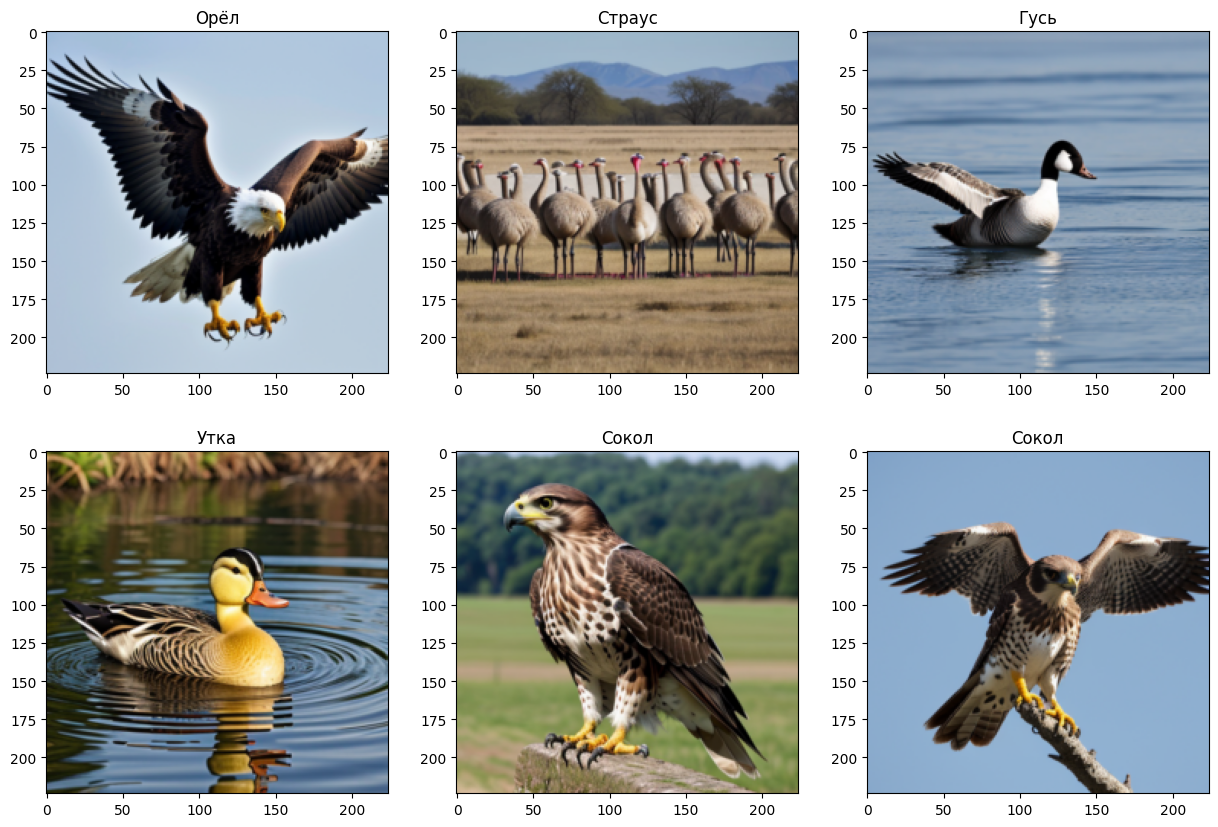

In [50]:
visualization_and_classification(model, test_loader, class_names)

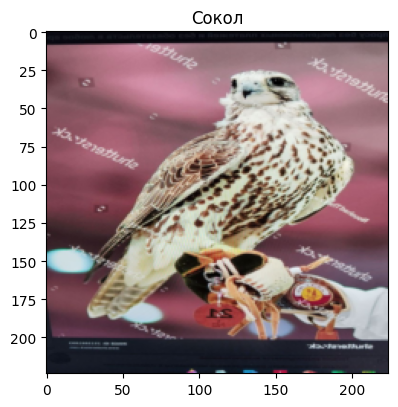

In [49]:
visualization_and_classification(model, pred_loader, class_names)

## –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –∏ –∑–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏

In [51]:
# torch.save(model, '/content/drive/MyDrive/Models/animals_linear_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/animals_cnn_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/animals_resnet50_model.pth')

# torch.save(model, '/content/drive/MyDrive/Models/birds_linear_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/birds_cnn_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/birds_resnet50_model.pth')

# torch.save(model, '/content/drive/MyDrive/Models/fanily_linear_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/family_cnn_model.pth')
# torch.save(model, '/content/drive/MyDrive/Models/family_resnet50_model.pth')

In [48]:
# model = torch.load('/content/drive/MyDrive/Models/animals_linear_model.pth', map_location=params_dict['device'])
# model = torch.load('/content/drive/MyDrive/Models/animals_cnn_model.pth', map_location=params_dict['device'])
# model = torch.load('/content/drive/MyDrive/Models/animals_resnet50_model.pth', map_location=params_dict['device'])

# model = torch.load('/content/drive/MyDrive/Models/birds_linear_model.pth', map_location=params_dict['device'])
# model = torch.load('/content/drive/MyDrive/Models/birds_cnn_model.pth', map_location=params_dict['device'])
model = torch.load('/content/drive/MyDrive/Models/birds_resnet50_model.pth', map_location=params_dict['device'])

# model = torch.load('/content/drive/MyDrive/Models/family_resnet50_model.pth', map_location=params_dict['device'])

<ipython-input-48-6ef5172a338e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Models/birds_resnet50_model.pth', map_location=pa

## TelegramBot (aiogram)

In [13]:
! pip install aiogram

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 595.4/595.4 kB 8.5 MB/s eta 0:00:00


In [14]:
! pip install asyncio

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 101.8/101.8 kB 2.5 MB/s eta 0:00:00


## –ò–º–ø–æ—Ä—Ç—ã

In [52]:
import asyncio
import nest_asyncio
from aiogram.fsm.storage.memory import MemoryStorage
from aiogram import Bot, Dispatcher
from aiogram import F, Router
from aiogram.filters import Command
from aiogram.types import Message
from aiogram.utils.keyboard import ReplyKeyboardBuilder
from aiogram.types import ReplyKeyboardMarkup
from PIL import Image

In [53]:
async def main(maintenance_mode: bool = False):

  # BOT_TOKEN. –í –æ–±—â–µ–º –¥–æ—Å—Ç—É–ø–µ –Ω–µ –≤—ã–ª–æ–∂–µ–Ω.
  # BOT_TOKEN = 'BOT_TOKEN'
  bot = Bot(token=BOT_TOKEN)
  # –¥–∏—Å–ø–µ—Ç—á–µ—Ä –æ–±—Ä–∞–±–æ—Ç—á–∏–∫–æ–≤
  dp = Dispatcher(maintenance_mode=maintenance_mode, storage=MemoryStorage())
  router = Router()

  # –°–æ–∑–¥–∞—ë—Ç ReplyKeyboard
  async def get_reply_keyboard(buttons_text: list, adjust: list, resize_keyboard: bool = True, one_time_keyboard: bool = False) -> ReplyKeyboardMarkup:
      builder = ReplyKeyboardBuilder()
      for button_text in buttons_text:
          builder.button(text=button_text)
      builder.adjust(*adjust)
      return builder.as_markup(resize_keyboard=resize_keyboard, one_time_keyboard=one_time_keyboard)

  # –ö–æ–º–∞–Ω–¥–∞ start/—Å—Ç–∞—Ä—Ç
  @router.message(Command(commands=['start', '—Å—Ç–∞—Ä—Ç']))
  async def cmd_start(message: Message):
    try:
      keyboard = await get_reply_keyboard(buttons_text=['ü¶Ü-linear', 'ü¶Ü-cnn', 'ü¶Ü-resnet50', 'üêï-linear', 'üêï-cnn', 'üêï-resnet50', 'üë±‚Äç‚ôÇÔ∏è-resnet50'], adjust=[3, 3, 1])
      await message.answer(text=f'–Ø —É–º–µ—é –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è.\n–ü–æ–∂–∞–ª—É–π—Å—Ç–∞, –≤—ã–±–µ—Ä–∏—Ç–µ –æ–¥–Ω—É –∏–∑ {len(models)} –æ–±—É—á–µ–Ω–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π:', reply_markup=keyboard)
    except Exception as err:
      await message.answer(text='–ù–µ –ø–æ–Ω—è–ª –ø–æ—Å–ª–µ–¥–Ω—é—é –∫–æ–º–∞–Ω–¥—É.\n–ü–æ–≤—Ç–æ—Ä–∏—Ç–µ, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞.')

  # –î–∞—Ç–∞—Å–µ—Ç - birds, –º–æ–¥–µ–ª—å - linear
  @router.message(F.text == 'ü¶Ü-linear')
  async def set_birds_linear(message: Message):
    try:
      global model, class_names
      model = models['birds_linear']
      class_names = all_class_names['birds']

      await message.answer(text=f'–í—ã –≤—ã–±—Ä–∞–ª–∏ –ª–∏–Ω–µ–π–Ω—É—é –º–æ–¥–µ–ª—å\n–ü–æ–∂–∞–ª—É–π—Å—Ç–∞, –æ—Ç–ø—Ä–∞–≤—å—Ç–µ –º–Ω–µ —Ñ–æ—Ç–æ –ø—Ç–∏—Ü—ã')
    except Exception as err:
      await message.answer(text='–ù–µ –ø–æ–Ω—è–ª –ø–æ—Å–ª–µ–¥–Ω—é—é –∫–æ–º–∞–Ω–¥—É.\n–ü–æ–≤—Ç–æ—Ä–∏—Ç–µ, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞.')

  # –î–∞—Ç–∞—Å–µ—Ç - birds, –º–æ–¥–µ–ª—å - cnn
  @router.message(F.text == 'ü¶Ü-cnn')
  async def set_birds_cnn(message: Message):
    try:
      global model, class_names
      model = models['birds_cnn']
      class_names = all_class_names['birds']
      await message.answer(text=f'–í—ã –≤—ã–±—Ä–∞–ª–∏ cnn-–º–æ–¥–µ–ª—å\n–ü–æ–∂–∞–ª—É–π—Å—Ç–∞, –æ—Ç–ø—Ä–∞–≤—å—Ç–µ –º–Ω–µ —Ñ–æ—Ç–æ –ø—Ç–∏—Ü—ã')
    except Exception as err:
      await message.answer(text='–ù–µ –ø–æ–Ω—è–ª –ø–æ—Å–ª–µ–¥–Ω—é—é –∫–æ–º–∞–Ω–¥—É.\n–ü–æ–≤—Ç–æ—Ä–∏—Ç–µ, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞.')

  # –î–∞—Ç–∞—Å–µ—Ç - birds, –º–æ–¥–µ–ª—å - resnet50
  @router.message(F.text == 'ü¶Ü-resnet50')
  async def set_birds_resnet50(message: Message):
    try:
      global model, class_names
      model = models['birds_resnet50']
      class_names = all_class_names['birds']
      await message.answer(text=f'–í—ã –≤—ã–±—Ä–∞–ª–∏ resnet50-–º–æ–¥–µ–ª—å\n–ü–æ–∂–∞–ª—É–π—Å—Ç–∞, –æ—Ç–ø—Ä–∞–≤—å—Ç–µ –º–Ω–µ —Ñ–æ—Ç–æ –ø—Ç–∏—Ü—ã')
    except Exception as err:
      await message.answer(text='–ù–µ –ø–æ–Ω—è–ª –ø–æ—Å–ª–µ–¥–Ω—é—é –∫–æ–º–∞–Ω–¥—É.\n–ü–æ–≤—Ç–æ—Ä–∏—Ç–µ, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞.')

  # –î–∞—Ç–∞—Å–µ—Ç - animals, –º–æ–¥–µ–ª—å - linear
  @router.message(F.text == 'üêï-linear')
  async def set_animals_linear(message: Message):
    try:
      global model, class_names
      model = models['animals_linear']
      class_names = all_class_names['animals']
      await message.answer(text=f'–í—ã –≤—ã–±—Ä–∞–ª–∏ –ª–∏–Ω–µ–π–Ω—É—é –º–æ–¥–µ–ª—å\n–ü–æ–∂–∞–ª—É–π—Å—Ç–∞, –æ—Ç–ø—Ä–∞–≤—å—Ç–µ –º–Ω–µ —Ñ–æ—Ç–æ –∂–∏–≤–æ—Ç–Ω–æ–≥–æ')
    except Exception as err:
      await message.answer(text='–ù–µ –ø–æ–Ω—è–ª –ø–æ—Å–ª–µ–¥–Ω—é—é –∫–æ–º–∞–Ω–¥—É.\n–ü–æ–≤—Ç–æ—Ä–∏—Ç–µ, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞.')

  # –î–∞—Ç–∞—Å–µ—Ç - animals, –º–æ–¥–µ–ª—å - cnn
  @router.message(F.text == 'üêï-cnn')
  async def set_animals_cnn(message: Message):
    try:
      global model, class_names
      model = models['animals_cnn']
      class_names = all_class_names['animals']
      await message.answer(text=f'–í—ã –≤—ã–±—Ä–∞–ª–∏ cnn-–º–æ–¥–µ–ª—å\n–ü–æ–∂–∞–ª—É–π—Å—Ç–∞, –æ—Ç–ø—Ä–∞–≤—å—Ç–µ –º–Ω–µ —Ñ–æ—Ç–æ –∂–∏–≤–æ—Ç–Ω–æ–≥–æ')
    except Exception as err:
      await message.answer(text='–ù–µ –ø–æ–Ω—è–ª –ø–æ—Å–ª–µ–¥–Ω—é—é –∫–æ–º–∞–Ω–¥—É.\n–ü–æ–≤—Ç–æ—Ä–∏—Ç–µ, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞.')

  # –î–∞—Ç–∞—Å–µ—Ç - animals, –º–æ–¥–µ–ª—å - resnet50
  @router.message(F.text == 'üêï-resnet50')
  async def set_animals_resnet50(message: Message):
    try:
      global model, class_names
      model = models['animals_resnet50']
      class_names = all_class_names['animals']
      await message.answer(text=f'–í—ã –≤—ã–±—Ä–∞–ª–∏ resnet50-–º–æ–¥–µ–ª—å\n–ü–æ–∂–∞–ª—É–π—Å—Ç–∞, –æ—Ç–ø—Ä–∞–≤—å—Ç–µ –º–Ω–µ —Ñ–æ—Ç–æ –∂–∏–≤–æ—Ç–Ω–æ–≥–æ')
    except Exception as err:
      await message.answer(text='–ù–µ –ø–æ–Ω—è–ª –ø–æ—Å–ª–µ–¥–Ω—é—é –∫–æ–º–∞–Ω–¥—É.\n–ü–æ–≤—Ç–æ—Ä–∏—Ç–µ, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞.')

  # –î–∞—Ç–∞—Å–µ—Ç - family, –º–æ–¥–µ–ª—å - resnet50
  @router.message(F.text == 'üë±‚Äç‚ôÇÔ∏è-resnet50')
  async def set_family_resnet50(message: Message):
    try:
      global model, class_names
      model = models['family_resnet50']
      class_names = all_class_names['family']
      await message.answer(text=f'–í—ã –≤—ã–±—Ä–∞–ª–∏ resnet50-–º–æ–¥–µ–ª—å\n–ü–æ–∂–∞–ª—É–π—Å—Ç–∞, –æ—Ç–ø—Ä–∞–≤—å—Ç–µ –º–Ω–µ —Ñ–æ—Ç–æ —á–µ–ª–æ–≤–µ–∫–∞')
    except Exception as err:
      await message.answer(text='–ù–µ –ø–æ–Ω—è–ª –ø–æ—Å–ª–µ–¥–Ω—é—é –∫–æ–º–∞–Ω–¥—É.\n–ü–æ–≤—Ç–æ—Ä–∏—Ç–µ, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞.')

  # –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å –æ—Ç–ø—Ä–∞–≤–∏–ª photo
  @router.message(F.photo)
  async def get_photo(message: Message):
    try:
      image_path = '/content/drive/MyDrive/Images/Photo_pred/pred/image.png'
      # —Å–æ—Ö—Ä–∞–Ω—è–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –ø–æ–≤–µ—Ä—Ö –∏–º–µ—é—â–µ–≥–æ—Å—è
      await message.bot.download(file=message.photo[-1].file_id, destination=image_path)

      pred_dataset = datasets.ImageFolder(root=pred_dataset_path, transform=transform)
      pred_loader = DataLoader(pred_dataset, batch_size=params_dict['batch_size'], shuffle=False)

      class_name = get_classes(model=model, loader=pred_loader, class_names=class_names)[0]

      await message.answer(text=f'–ò–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –∑–∞–≥—Ä—É–∂–µ–Ω–æ.\n\n–≠—Ç–æ {class_name}')
    except Exception as err:
      await message.answer(text='–ù–µ –ø–æ–Ω—è–ª –ø–æ—Å–ª–µ–¥–Ω—é—é –∫–æ–º–∞–Ω–¥—É.\n–ü–æ–≤—Ç–æ—Ä–∏—Ç–µ, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞.')

  # –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å –æ—Ç–ø—Ä–∞–≤–∏–ª –ª—é–±–æ–µ —Å–æ–æ–±—â–µ–Ω–∏–µ (–Ω–µ photo)
  @router.message()
  async def unknown_message(message: Message):
    try:
      await message.reply(f'–Ø –Ω–µ –∑–Ω–∞—é —á—Ç–æ —Å —ç—Ç–∏–º –¥–µ–ª–∞—Ç—å')
    except Exception as err:
      await message.answer(text='–Ø –µ—â—ë —É—á—É—Å—å.\n–ü–æ–∫–∞ —è —É–º–µ—é —Ç–æ–ª—å–∫–æ –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è.')
    finally:
      await message.answer(text='–Ø –µ—â—ë —É—á—É—Å—å.\n–ü–æ–∫–∞ —è —É–º–µ—é —Ç–æ–ª—å–∫–æ –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è.')

  # –ø–æ–¥–∫–ª—é—á–∞–µ–º –æ–±—Ä–∞–±–æ—Ç—á–∏–∫–∏
  dp.include_router(router)
  # –£–¥–∞–ª—è–µ–º –≤—Å–µ –æ–±–Ω–æ–≤–ª–µ–Ω–∏—è, –∫–æ—Ç–æ—Ä—ã–µ –ø—Ä–æ–∏–∑–æ—à–ª–∏ –ø–æ—Å–ª–µ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ –∑–∞–≤–µ—Ä—à–µ–Ω–∏—è —Ä–∞–±–æ—Ç—ã –±–æ—Ç–∞
  await bot.delete_webhook(drop_pending_updates=True)
  # –ü–æ–ª–ª–∏–Ω–≥ –Ω–æ–≤—ã—Ö –∞–ø–¥–µ–π—Ç–æ–≤
  await dp.start_polling(bot)

In [54]:
if __name__ == "__main__":

  # –∫–ª–∞—Å—Å—ã –¥–ª—è —Ä–∞–∑–Ω—ã—Ö –¥–∞—Ç–∞—Å–µ—Ç–æ–≤
  all_class_names = {'animals' : ['–ê–Ω—Ç–∏–ª–æ–ø–∞', '–ë–∏–∑–æ–Ω', '–ë–æ–±–µÃà—Ä', '–ë—É–∏ÃÜ–≤–æ–ª', '–í–µ—Ä–±–ª—é–¥', '–í–æ–ª–∫', '–í—ã–¥—Ä–∞', '–ì–µ–ø–∞—Ä–¥', '–ì–∏–µ–Ω–∞', '–ì–∏–ø–ø–æ–ø–æ—Ç–∞–º', '–ì–æ—Ä–∏–ª–ª–∞', '–î–µ–ª—å—Ñ–∏–Ω',
                                  '–î–∏–∫–æ–±—Ä–∞–∑', '–ïÃà–∂', '–ï–Ω–æ—Ç', '–ñ–∏—Ä–∞—Ñ', '–ò–≥—É–∞–Ω–∞', '–ö–µ–Ω–≥—É—Ä—É', '–ö–∏—Ç', '–ö–æ–∞–ª–∞', '–ö–æ–∑–µÃà–ª', '–ö–æ—Ä–æ–≤–∞', '–ö–æ—à–∫–∞', '–ö—Ä–∞–±', '–ö—Ä–æ–∫–æ–¥–∏–ª',
                                  '–ö—Ä–æ—Ç', '–õ–µ–º—É—Ä', '–õ–µ–æ–ø–∞—Ä–¥', '–õ–∏—Å–∞', '–õ—è–≥—É—à–∫–∞', '–ú–∞–Ω–≥—É—Å', '–ú–µ–¥–≤–µ–¥—å', '–ú–æ—Ä–∂', '–û–≤—Ü–∞', '–û–ª–µ–Ω—å', '–û—Å–µÃà–ª', '–ü–∞–Ω–¥–∞', '–†—ã—Å—å',
                                  '–°–ª–æ–Ω', '–°–æ–±–∞–∫–∞', '–¢—é–ª–µ–Ω—å', '–•–æ—Ä–µÃà–∫', '–®–∏–º–ø–∞–Ω–∑–µ', '–®–∏–Ω—à–∏–ª–ª–∞', '–Ø–≥—É–∞—Ä', '–Ø—â–µ—Ä–∏—Ü–∞'],
                     'birds' : ['–ì—É—Å—å', '–û—Ä–µÃà–ª', '–ü–∞–≤–ª–∏–Ω', '–ü–∏–Ω–≥–≤–∏–Ω', '–°–æ–≤–∞', '–°–æ–∫–æ–ª', '–°—Ç—Ä–∞—É—Å', '–£—Ç–∫–∞', '–§–ª–∞–º–∏–Ω–≥–æ', '–ß–µÃà—Ä–Ω—ã–∏ÃÜ –¥—Ä–æ–∑–¥', '–Ø—Å—Ç—Ä–µ–±'],
                     'family' : ['–ö–∞—Ç—è', '–ú–∞–º–∞', '–ù–∞—Å—Ç—è', '–ü–∞–ø–∞', '–°–∞—à–∞'],
  }

  # –º–æ–¥–µ–ª–∏ (–∑–∞–≥—Ä—É–∑–∫–∞ –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω–æ –æ–±—É—á–µ–Ω–Ω—ã—Ö)
  models = {'birds_linear'     : torch.load('/content/drive/MyDrive/Models/birds_linear_model.pth', map_location=params_dict['device']),
            'birds_cnn'        : torch.load('/content/drive/MyDrive/Models/birds_cnn_model.pth', map_location=params_dict['device']),
            'birds_resnet50'   : torch.load('/content/drive/MyDrive/Models/birds_resnet50_model.pth', map_location=params_dict['device']),
            'animals_linear'   : torch.load('/content/drive/MyDrive/Models/animals_linear_model.pth', map_location=params_dict['device']),
            'animals_cnn'      : torch.load('/content/drive/MyDrive/Models/animals_cnn_model.pth', map_location=params_dict['device']),
            'animals_resnet50' : torch.load('/content/drive/MyDrive/Models/animals_resnet50_model.pth', map_location=params_dict['device']),
            'family_resnet50'  : torch.load('/content/drive/MyDrive/Models/family_resnet50_model.pth', map_location=params_dict['device']),
  }

  # –∫–ª–∞—Å—Å—ã –∏ –º–æ–¥–µ–ª—å –ø—Ä–∏ —Å—Ç–∞—Ä—Ç–µ –±–æ—Ç–∞
  class_names = all_class_names['birds']
  model = models['birds_cnn']

  nest_asyncio.apply()
  # —Ç–æ—á–∫–∞ –≤—Ö–æ–¥–∞
  asyncio.run(main())

<ipython-input-54-1408428cbd5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = {'birds_linear'     : torch.load('/content/drive/MyDrive/Models/birds_linear_model